<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/DGRNet%20STEP3-%20Hourly%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/500
604/604 [==============================] - 14s 17ms/step - loss: 0.9521 - mean_squared_error: 0.9521 - val_loss: 0.8596 - val_mean_squared_error: 0.8596
Epoch 2/500
604/604 [==============================] - 9s 14ms/step - loss: 0.8871 - mean_squared_error: 0.8871 - val_loss: 0.8283 - val_mean_squared_error: 0.8283
Epoch 3/500
604/604 [==============================] - 9s 14ms/step - loss: 0.8779 - mean_squared_error: 0.8779 - val_loss: 0.8244 - val_mean_squared_error: 0.8244
Epoch 4/500
604/604 [==============================] - 9s 15ms/step - loss: 0.8703 - mean_squared_error: 0.8703 - val_loss: 0.8341 - val_mean_squared_error: 0.8341
Epoch 5/500
604/604 [==============================] - 8s 13ms/step - loss: 0.8739 - mean_squared_error: 0.8739 - val_loss: 0.8223 - val_mean_squared_error: 0.8223
Epoch 6/500
604/604 [==============================] - 9s 15ms/step - loss: 0.8737 - mean_squared_error: 0.8737 - val_loss: 0.8300 - val_mean_squared_error: 0.8300
Epoch 7/500
604

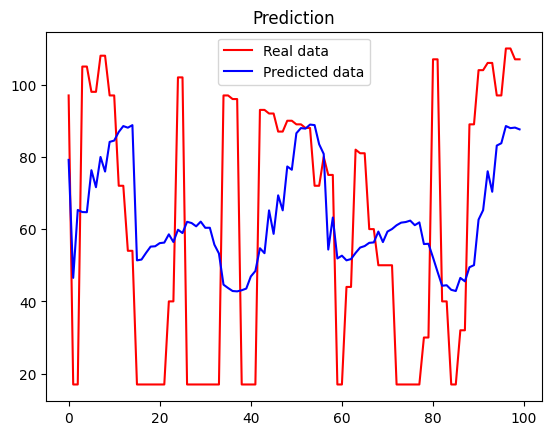

In [120]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
from keras.callbacks import Callback
import plotly
import plotly.express as px # for data visualization
import seaborn as sns

generator_multiply = 1 #each input record will generate 100 random vectors from the latent space, given the mu and sigma generated by the encoder

#from keras.utils import plot_model
#import matplotlib.pyplot as plt

#window1 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-500.npy')
#window2 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-1000.npy')
#window = np.concatenate((window1, window2), axis=0)
#train_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TRAIN.npy')
#test_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TEST.npy')



train_data = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences-TRAIN_hourly.npy') #------for Hourly data
index = 500
#We missed i=500 from processing the iosw. So here we are dropping row with index =500
train_data= np.delete(train_data, index, axis=0)


#test_data = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences-TEST_hourly.npy')
#all_data = np.concatenate((train_data,test_data),axis=0)
window_label = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences_WINDOW-TRAIN_hourly.npy')
n_seq = train_data.shape[0]
window_size = train_data.shape[1]
n_features = train_data.shape[2]


#---------------------------VAE ------------------------------------------
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(train_data, window_label, test_size = 0.2, random_state = 42)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

encoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/vae-encoder-saved-hourly-latent10-dim128-latest.model')
decoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/vae-decoder-saved-hourly-latent10-dim128-latest.model')

X_train_encoded = encoder.predict(train_data)
mu, logvar, z = X_train_encoded
sigma = tf.exp(0.5 * logvar)
batch = tf.shape(mu)[0]  #number of recors / batchs
dim = tf.shape(mu)[1] #Ndimension of latent variable
store = list()
storetemp = list()


#For each batch, iterate, get the generator_multipy number of latent vectors with same window_size.
#For each z, concatenate z_mean, so it will become 100 dimensional vector

for i in range(0,batch):
  all_Z_i = tf.random.normal(shape=(generator_multiply,dim), mean = mu[i,:], stddev=sigma[i,:]) #all randorm vectors for this record i
  X_train_decoded = decoder.predict(all_Z_i)
  X_train_decoded = X_train_decoded.reshape((X_train_decoded.shape[0],window_size*n_features))
  a = np.arange(generator_multiply)
  a.fill(window_label[i])
  c=np.concatenate(((X_train_decoded,a[:,None])),axis=1)
  store.append(c)

results1=np.concatenate(store,axis=0)
results1=np.load(r'/content/drive/MyDrive/PHD/2024/labelled_subsquence_data_hourly.npy')
np.save(r'/content/drive/MyDrive/PHD/2024/labelled_subsquence_data_hourly',results1)


#Regression fitting
x=results1[:,:-1]
y=results1[:,window_size*n_features]


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#----- get a test set from this data, to avoid further wrangling----------------
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)


maxval = x.shape[0]
count_train = int(math.ceil(0.9*maxval))
x_train = x[:count_train]
x_test = x[count_train:]

y_train = y[:count_train]
y_test = y[count_train:]


from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.4)
yhat = iso.fit_predict(x_train)
# select all rows that are not outliers
mask = yhat != -1
x_train, y_train = x_train[mask, :], y_train[mask]

x_train = x_train.reshape((x_train.shape[0], window_size, n_features))  #DONT RUN IF MLP
x_test = x_test.reshape((x_test.shape[0], window_size, n_features))    #DONT RUN IF MLP


from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()

y_train_transformed = transformer.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_transformed = transformer.fit_transform(y_test.reshape(-1,1)).flatten()


from keras.layers import LeakyReLU

model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units = 64))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units = 32))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units = 16))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units = 8))
model.add(LeakyReLU(alpha=0.1))



model.add(Dense(units = 1))

#sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizr = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer= optimizr, metrics=['mean_squared_error'])
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])


#reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
es = keras.callbacks.EarlyStopping(patience=20, verbose=1, min_delta=0.001, monitor='loss', mode='auto', restore_best_weights=True)
n_epochs = 500
#model.fit(x_train, y_train,epochs=5, batch_size=50, verbose=True)

#y_pred = model.predict(x_test)

#transform


history=model.fit( x_train,y_train_transformed,
                 epochs=n_epochs,
                 batch_size=50,
                   validation_split=0.1,
                 callbacks=[es])

y_train_pred = model.predict(x_train)
y_train_pred = transformer.inverse_transform(y_train_pred)

y_pred = model.predict(x_test)
y_pred = transformer.inverse_transform(y_pred)


score_train= r2_score(y_train,y_train_pred)
print("r2 score is ==",score_train)

score= r2_score(y_test,y_pred)
print("r2 score is ==",score)



#plt.scatter(y_test,y_pred);
#plt.xlabel('Actual');
#plt.ylabel('Predicted');
plt.plot(y_train[0:100], color = 'red', label = 'Real data')
plt.plot(y_train_pred[0:100], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()



np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/preduber_2.csv',y_pred)
np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/realuber_2.csv',y_test)
print("MAE is==",mean_absolute_error(y_test,y_pred))

#---------------------------------Without VAE------------------------------------

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error



maxval = train_data.shape[0]
count_train = int(math.ceil(0.9*maxval))
x_train = train_data[:count_train]
x_test = train_data[count_train:]

y_train = window_label[:count_train]
y_test = window_label[count_train:]

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]*n_features))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]*n_features))

from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(x_train)
# select all rows that are not outliers
mask = yhat != -1
x_train, y_train = x_train[mask, :], y_train[mask]


x_train = x_train.reshape((x_train.shape[0], window_size, n_features))  #DONT RUN IF MLP
x_test = x_test.reshape((x_test.shape[0], window_size, n_features))    #DONT RUN IF MLP

from keras.layers import Dense, Activation
from keras.models import Sequential
##!pip uninstall tensorflow
#!pip install tensorflow==2.12.0
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
es = keras.callbacks.EarlyStopping(patience=10, verbose=1, min_delta=0.01, monitor='loss', mode='auto', restore_best_weights=True)
n_epochs = 100

model = Sequential()
model.add(LSTM(512, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

history=model.fit( x_train,y_train,
                 epochs=n_epochs,
                 batch_size=32,
                   validation_split=0.1,
                 callbacks=[es,reduce_lr])


y_pred = model.predict(x_test)


score= r2_score(y_test,y_pred)
print("r2 score is ==",score)
print("mean_sqrd_error is==",mean_squared_error(y_test,y_pred))
print("root_mean_squared error of is==",np.sqrt(mean_squared_error(y_test,y_pred)))

#plt.scatter(y_test,y_pred);
#plt.xlabel('Actual');
#plt.ylabel('Predicted');
plt.plot(y_test[0:100], color = 'red', label = 'Real data')
plt.plot(y_pred[0:100], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

#Loss


plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['kl_loss'], loc='upper left')
plt.legend()
plt.grid(True)
#plt.ylim(0, 100)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')